In [1]:
# Manipulacion
import pandas as pd
import numpy as np

# Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

# Modelos y operaciones 
import sklearn

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# El XGBoost
from sklearn.ensemble import GradientBoostingClassifier 

# Evaluación de modelos
from sklearn import metrics # Evaluación de modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

#regex
import re

#matplotlib
import matplotlib
import matplotlib.pyplot as plt

# Cargar modelos
import pickle 

# Shap
import shap

# Dashboard
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

# Ocultar warnings
import warnings
warnings.filterwarnings('ignore')


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


In [2]:
# Leemos datos
xtrain = pd.read_parquet("../data/xtrain.parquet")
ytrain = pd.read_parquet("../data/ytrain.parquet")['fatality']
xtest = pd.read_parquet("../data/xtest.parquet")
ytest = pd.read_parquet("../data/ytest.parquet")['fatality']

# explainerdashboard no acepta el caracter "." como nombre en ninguna de sus variables. Las quitamos
xtest.rename(columns={'passenger_sex_0.0':'pasenger_sex_0', 'passenger_sex_1.0':'passenger_sex_1'}, inplace=True)

# Explicabilidad e interpretabilidad

Utilizamos la librería pickle para cargar el modelo optimizado que generamos en el notebook anterior

In [3]:
# Cargamos modelo optimizado
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/LightGBM_pipeline.pickle', 'rb') as f:
    clf = pickle.load(f)

clf.best_params_

{'importance_type': 'split',
 'is_unbalance': True,
 'learning_rate': 0.05,
 'max_depth': -1,
 'n_estimators': 300,
 'num_leaves': 200,
 'objective': 'binary'}

Generamos las predicciones de la serie test

In [4]:
# Generamos predicciones
ypred = clf.predict(xtest)
ypred_proba = clf.predict_proba(xtest)

## Curva de Ganancia (Gain Curve)

La curva de ganancia nos permite analizar el porcentaje de los accidentes que queremos utilizar como *target* a la hora de realizar nuestro análisis.
En el eje X tenemos el porcentaje de datos de validación escogido como sample, de manera que siempre se escogen primero los datos con mayor probabilidad de ser de la clase positiva.
En el eje Y tenemos el porcentaje de datos de la clase positiva encontrados, en comparación con los que encontramos en nuestro modelo completo.

Por ejemplo y para nuestro caso concreto, la Gain Curve nos permite observar que analizando el 20% de los accidentes del conjunto de test con mayor probabilidad de ser mortales, conseguiríamos detectar alrededor de un 70% de los que detectamos analizando el conjunto completo de los datos. Según avanzamos sobre el eje X de la curva de ganancia, su pendiente va siendo menor por que vamos añadiendo datos al sample sobre los cuales no tenemos tanta certeza.

Asímismo, podemos afirmar que analizando el 60% de los datos conseguiríamos captar más del 90% de los casos positivos captados por el modelo



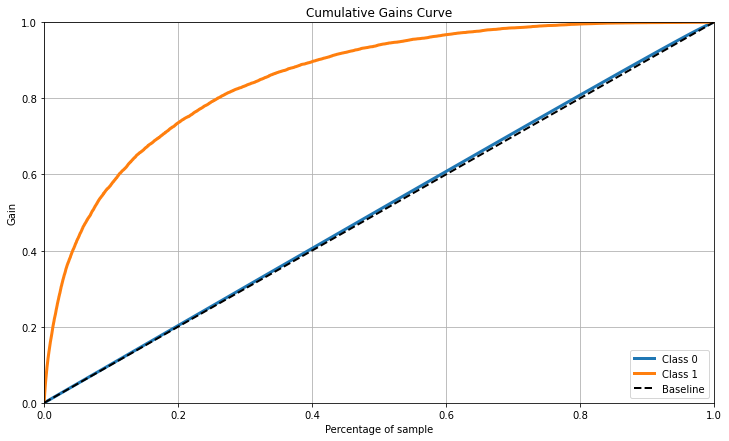

In [5]:
# Gain curve (curva de ganancia acumulada)
skplt.metrics.plot_cumulative_gain(ytest, ypred_proba, figsize=(12, 7));

## Curva ROC

La curva ROC es una representación gráfica que combina los valores de *sensitividad* = $TP/(TP+FN)$ y *especificabilidad*= $TN/(TN+FP)$, de manera que para los distintos thresholds que ya mencionamos previamente. Si para un threshold concreto de la curva ROC la probabilidad de clasificar un valor como clase positiva se encuentra por encima de la curva ROC, lo clasificaremos como clase positiva. Si se encuentra por debajo, le otorgaremos clase negativa.

El eje Y mide la probabilidad de predecir correctamente un valor positivo, mientras que el eje X mide la probabilidad de predecir incorrectamente un valor negativo.

En un escenario óptimo (no es el caso), el eje Y será 1 para todo el recorrido de la curva ROC.

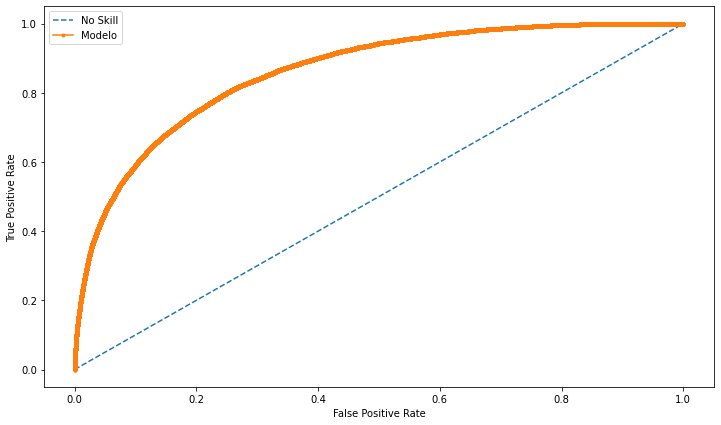

In [6]:
    # keep probabilities for the positive outcome only
    matplotlib.rcParams['figure.figsize'] = (12, 7)
    yhat = ypred_proba[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(ytest, yhat)
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label="Modelo")
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()

## Curva Lift

La curva Lift está relacionada con la previamente mencionada curva de Ganancia o Gain Curve, siendo su eje X el mismo.
Sin embargo, el eje Y de la Curva Lift representa la ganancia de nuestro modelo respecto a un modelo aleatorio.

Sabiendo esto podemos conocer más sobre nuestro modelo y observar que tiene facilidad para predecir correctamente la clase positiva (mortalidad) para los valores que tiene más "claros", pero rápidamente sufre una bajada y acaba pareciéndose a un modelo aleatorio. Esto puede deberse a dos razones que no son excluyentes:

- Los datos no son fácilmente clasificables y por lo tanto es inevitable equivocarse a la hora de clasificar los valores que no son *claros*

- De alguna manera el procesamiento de los datos que hemos utilizado ha supuesto una omisión de información importante que hubiese podido ayudar al modelo a identificar correctamente aquellos puntos más complejos o difíciles de identificar.

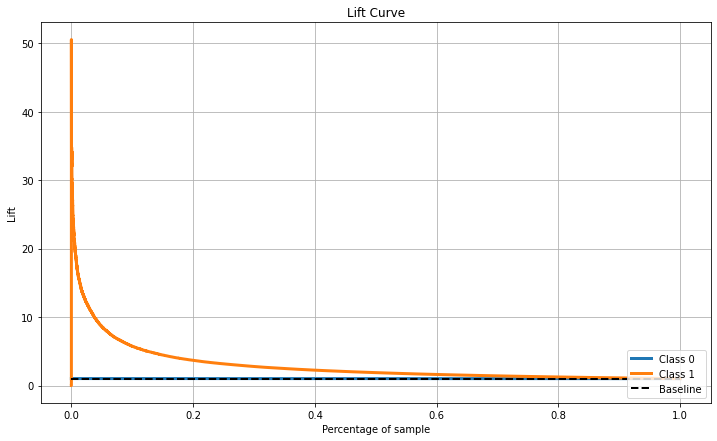

In [7]:
# lift curve
skplt.metrics.plot_lift_curve(ytest, ypred_proba, figsize=(12, 7));

## Importancia de variables

Del modelo extraemos la importancia de las variables y generamos una tupla, para poder representarlas en un *plot*

In [8]:
datos_importancia_variables = clf.best_estimator_.feature_importances_

importancia_variables = sorted(
                              list(zip(xtest.columns,
                                       datos_importancia_variables)),
    
    key=lambda tupla: tupla[1],
    reverse=True)

importancia_variables = pd.DataFrame(importancia_variables)
importancia_variables.rename(columns={ 0: 'Variable',  1: 'Importancia'}, inplace=True)


### Plot de importancia de variables

Podemos observar cómo el modelo otorga a variables como la edad del conductor, el año en el que ocurrió el accidente o el tipo de accidente una mayor importancia

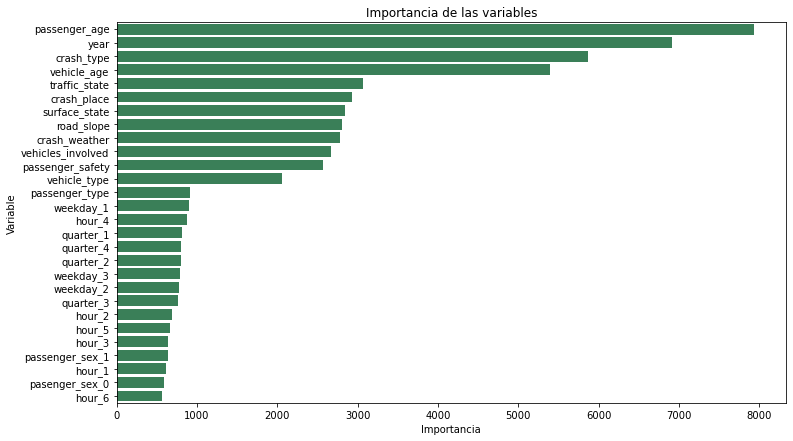

In [9]:
plt.figure(figsize=(12, 7))

sns.barplot(x='Importancia',
            y='Variable', 
            data=importancia_variables, 
            color='seagreen')

plt.title('Importancia de las variables');

## SHAP

Utilizamos la librería SHAP para generar los valores SHAP del modelo

In [10]:
shap.initjs()
model = clf.best_estimator_
explainer = shap.TreeExplainer(model)

In [16]:
shap_values = explainer.shap_values(xtest)

In [11]:
# Para no tener que ejecutar
with open('../models/shap_values.pickle', 'rb') as f:
    shap_values = pickle.load(f)

In [12]:
base_value = explainer.expected_value.item()

In [ ]:
with open('../models/shap_values.pickle', 'wb') as f:
    pickle.dump(shap_values, f)

### Explicación de observaciones individuales

SHAP nos permite representar la decisión de nuestro modelo para observaciones individuales.

Por ejemplo, para la linea 402 del conjunto de test (que terminó en un accidente de tráfico mortal) podemos observar como el modelo "argumenta" a favor de que se trate de un accidente mortal por el lugar en el que ocurrió el accidente o la pendiente de la carretera.

In [13]:
# una sola linea, explicada
shap.force_plot(explainer.expected_value[0], shap_values[1][402], xtest.iloc[402,:])

Para la linea 163 del conjunto de test, el modelo respalda su decisión de *no mortal* por features como el sexo del conductor, el estado del tráfico... 

In [14]:
shap.force_plot(explainer.expected_value[0], shap_values[1][163], xtest.iloc[163,:])

### Plot de dependencia

El plot de dependencia nos permite analizar como evolucionan los valores SHAP para una variable en función del valor concreto de una feature. 
Nosotros hemos seleccionado como muestra la variable *age*, y es fácilmente visible cómo existe una relación directamente proporcional entre la edad y el valor SHAP de esta variable.

Cabe mencionar que observamos cierto *bunching* de valores alrededor del valor 0, lo cual es debido a la imputación de valores NA por la mediana de la edad que realizamos durante el preprocesamiento.

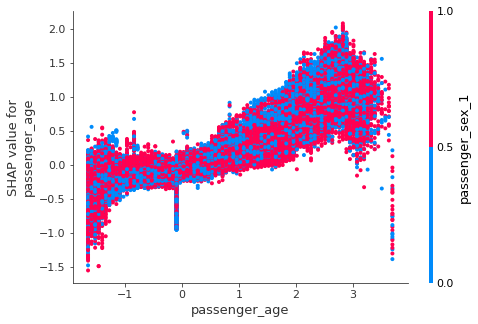

In [15]:
variable = 'passenger_age'

shap.dependence_plot(variable, shap_values[1], xtest, interaction_index="passenger_sex_1")

### Plot de sumario

SHAP nos permite también realizar un gráfico similar al que obtuvimos mediante el análisis de las *feature importances* del modelo, pero conociendo en mayor profundidad cual es la importancia de cada variable a la hora de determinar cada una de las clases objetivo. En nuestro caso, al tratarse de un problema de clasificación binario, estas son dos.

Del gráfico extraemos que según SHAP la variable más importante es el tipo de accidente, así como el estado del tráfico o el tipo de vehículo.

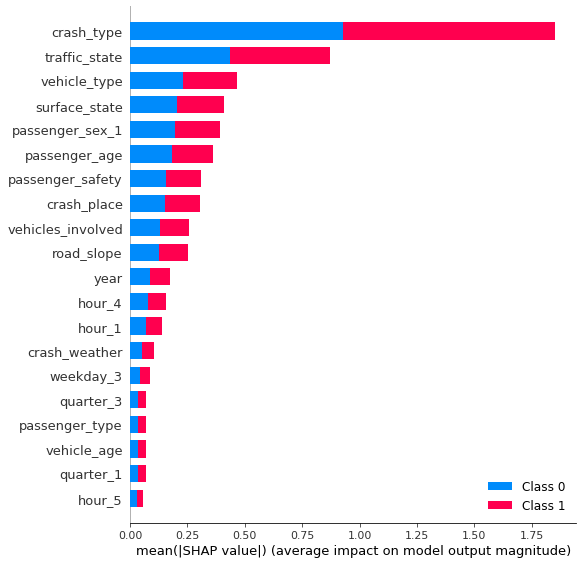

In [16]:
shap.summary_plot(shap_values, xtest)

### Sumario *polarizado*

Esta versión más avanzada del plot de sumario nos permite también analizar la relación entre los valores SHAP y el valor de la variable, para conseguir entender qué valores de qué variables son los que tienden a generar un valor positivo según SHAP.

Analizando en concreto podemos observar como la variable *passenger_sex_1*, que determina si el conductor es hombre o mujer, toma mayores valores de SHAP cuando su valor es alto (hombre). Esto nos indica que un hombre es una variable a ponderar positivamente a la hora de determinar si un accidente es mortal o no.

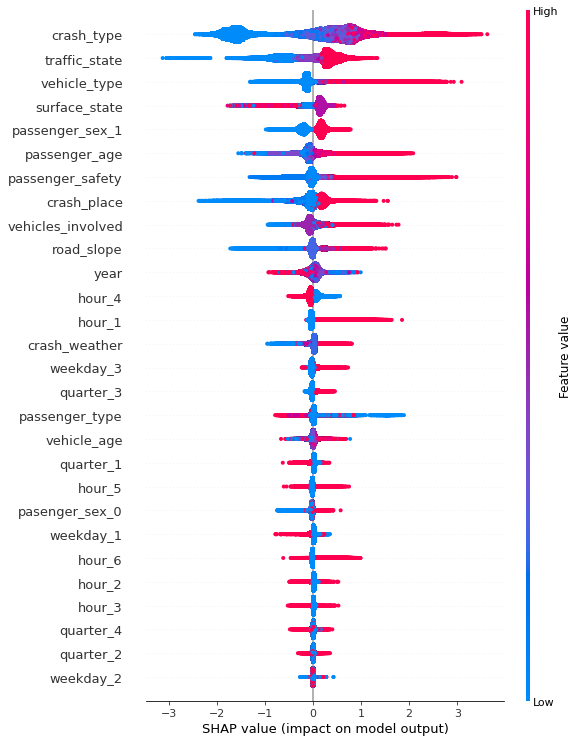

In [17]:
shap.summary_plot(shap_values[1], features=xtest, max_display=28)

## Dashboard

Nos proponemos la generación de un *dashboard* web que nos permita visualizar de manera interactiva los resultados obtenidos por nuestro modelo, acorde con los valores SHAP que hemos obtenido previamente.

Cabe mencionar que dashboardexplainer genera los valores SHAP por si mismo pero hemos introducido los generados previamente mediante *set_shap_values*, una función introducida apenas 10 días en el paquete y que aún no se encuentra actualizada para los metodos *conda install* o *pip install* por que todavía se trata de una versión experimental. Para poder ejecutar el código, hay que instalar el paquete dashboard explainer desde su repositorio github:
https://github.com/oegedijk/explainerdashboard

In [192]:
explainer = ClassifierExplainer(model, xtest, ytest)
base_value = list([-base_value, base_value])

Note: model_output=='probability'. For LGBMClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...


In [193]:
explainer.set_shap_values(base_value, shap_values)

### Aplicación web

Tras la configuración realizada mediante código, procedemos a ejecutar el Dashboard a nivel local.

En caso de preferir no ejecutar el dashboard, lo cual consume tiempo y poder computacional, hemos dejado el archivo **dashboard.html** en la carpeta reports, el cual permite la visualización del dashboard sin la capacidad interactiva.

Aquí se muestran imágenes seleccionadas de los resultados:




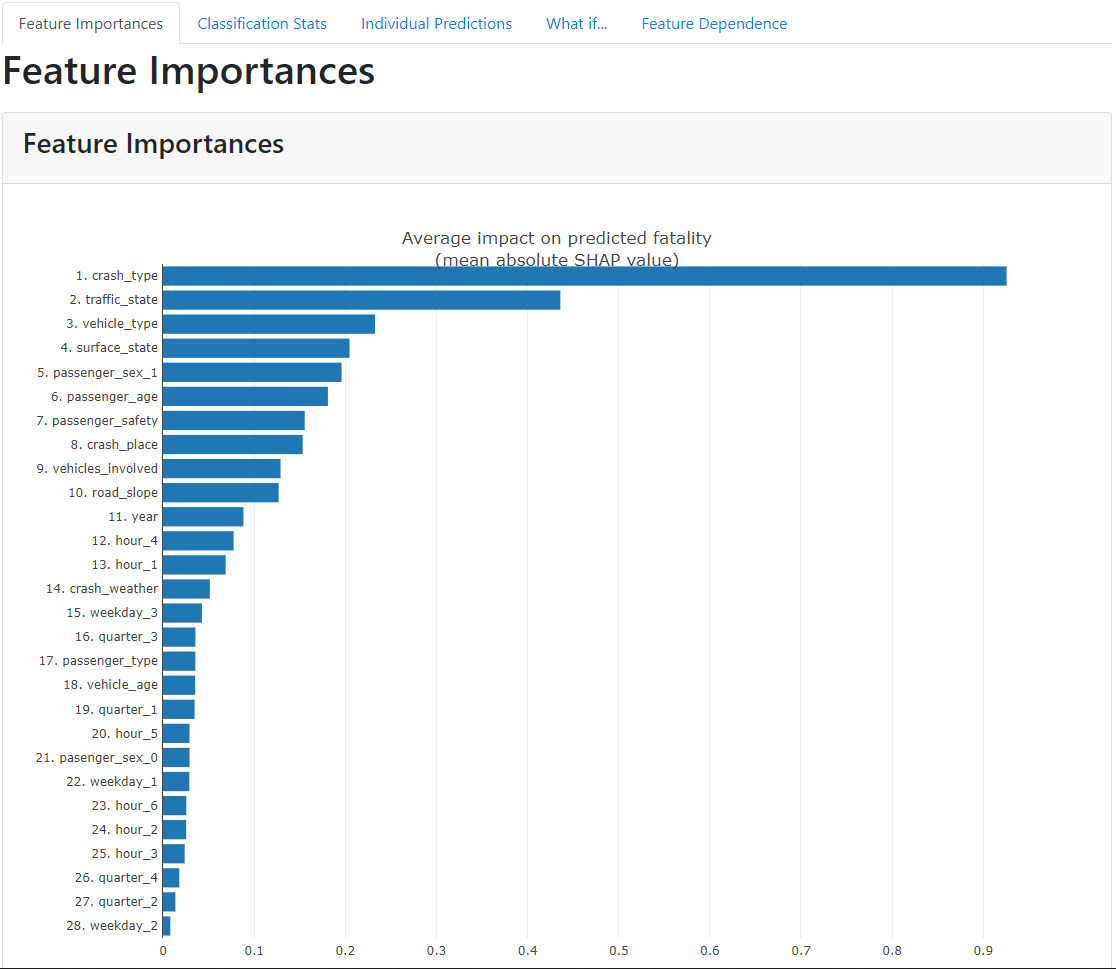

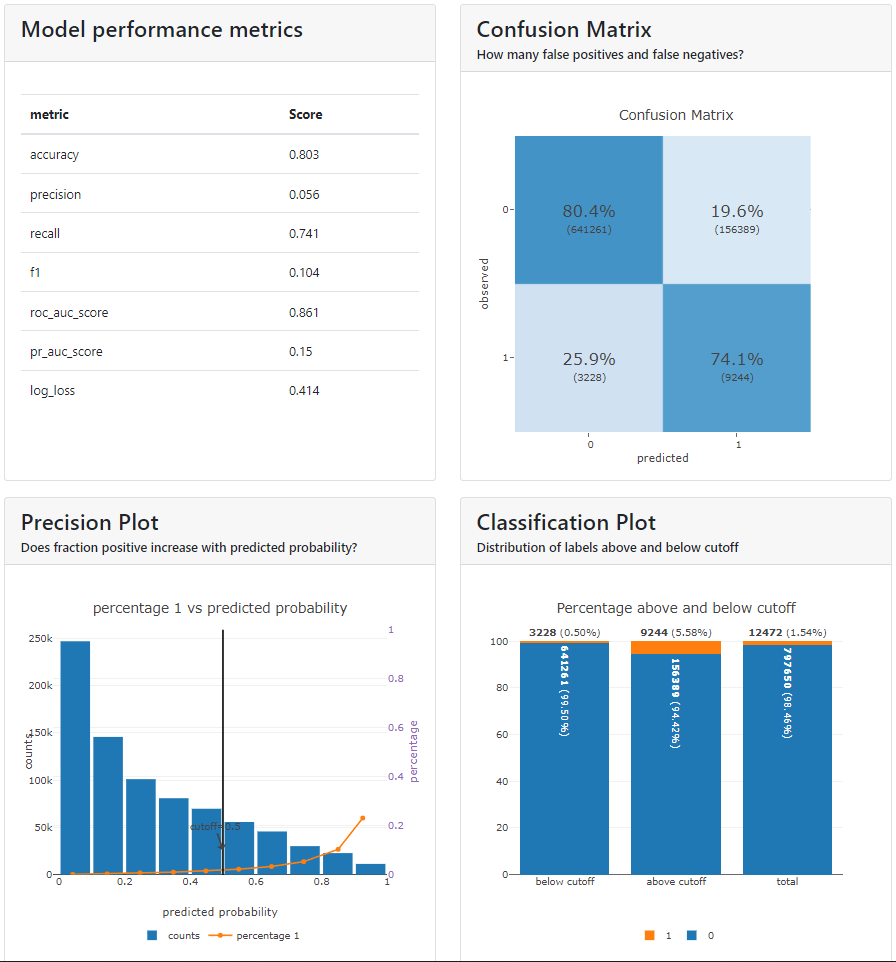

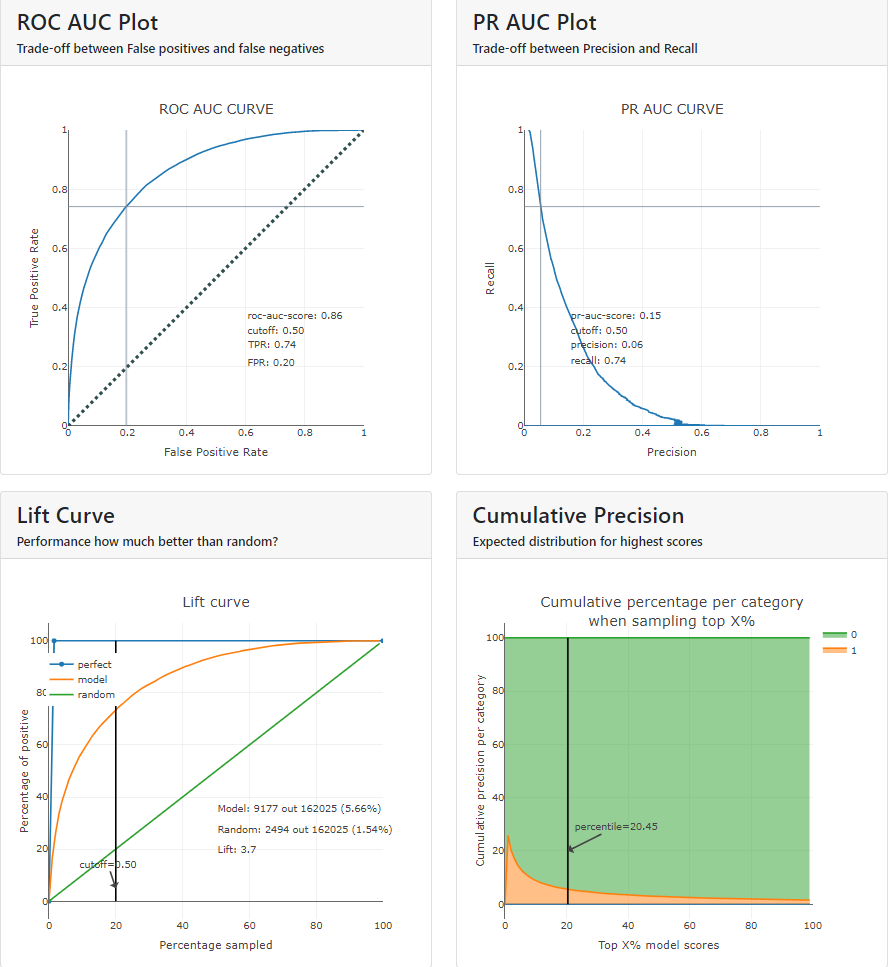

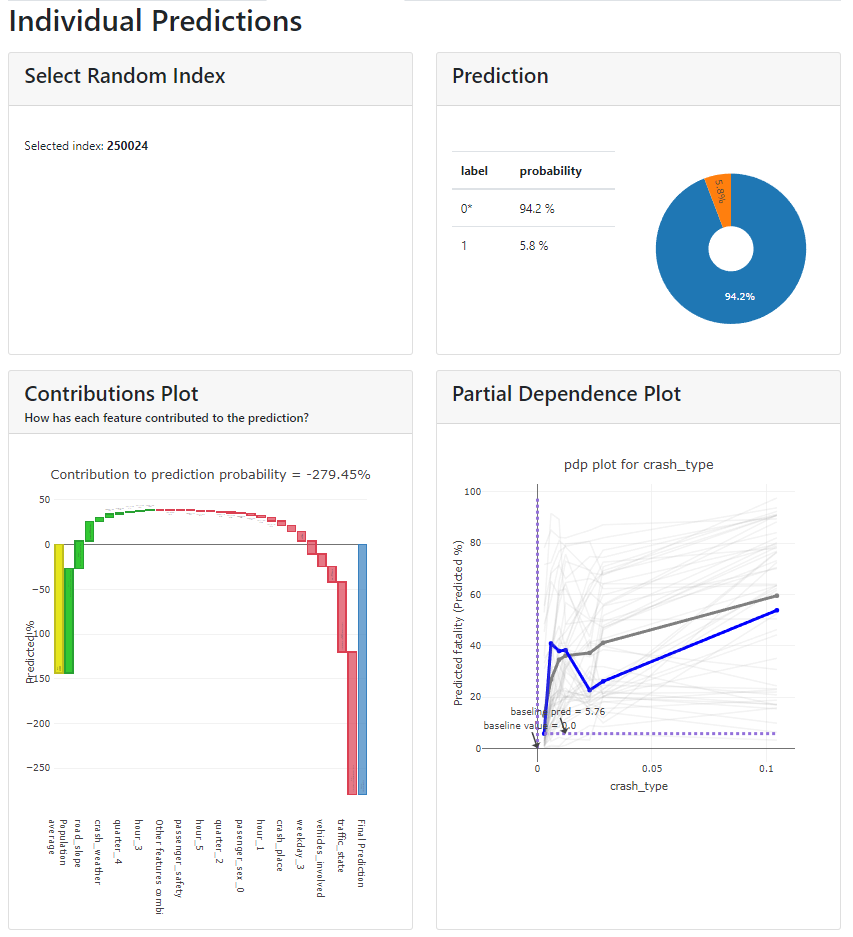

In [195]:
dashboard = ExplainerDashboard(explainer).run()
dashboard

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.1.134:8050
Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app 'explainerdashboard.dashboards

 * Running on all addresses.
 * Running on http://192.168.1.134:8050/ (Press CTRL+C to quit)
192.168.1.134 - - [15/Dec/2021 14:04:07] "GET / HTTP/1.1" 200 -
192.168.1.134 - - [15/Dec/2021 14:04:07] "GET /assets/bootstrap.min.css?m=1639569153.9529266 HTTP/1.1" 200 -
192.168.1.134 - - [15/Dec/2021 14:04:07] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_0_0m1632235559.12.1.min.js HTTP/1.1" 200 -
192.168.1.134 - - [15/Dec/2021 14:04:07] "GET /_dash-component-suites/dash/deps/react@16.v2_0_0m1632235559.14.0.min.js HTTP/1.1" 200 -
192.168.1.134 - - [15/Dec/2021 14:04:07] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_0_0m1632235559.14.0.min.js HTTP/1.1" 200 -
192.168.1.134 - - [15/Dec/2021 14:04:07] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_0_0m1632235559.7.2.min.js HTTP/1.1" 200 -
192.168.1.134 - - [15/Dec/2021 14:04:07] "GET /_dash-component-suites/dash_bootstrap_components/_components/dash_bootstrap_components.v0_13_1m1639569153.min.js HTTP/1.1" 200 -
192.168.